<a href="https://colab.research.google.com/github/tocom242242/anomaly_detection/blob/main/fashion_mnist/simple_ae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## データの読み込み

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
normal_idx = 5
abnormal_idx = 7

In [ ]:
x_normal_train = x_train[np.where(y_train==normal_idx,True,False)]
x_normal_test = x_test[np.where(y_test==normal_idx,True,False)]

In [ ]:
x_abnormal_train = x_train[np.where(y_train==abnormal_idx,True,False)]
x_abnormal_test = x_test[np.where(y_test==abnormal_idx,True,False)]

In [ ]:
# 正常が1,異常が0
y_test = np.concatenate((np.ones(x_normal_test.shape[0]),np.zeros(x_abnormal_test.shape[0])))

In [ ]:
x_test = np.concatenate((x_normal_test,x_abnormal_test))

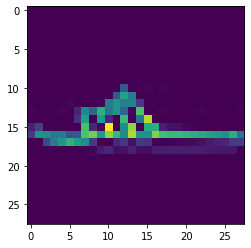

In [ ]:
plt.imshow(x_normal_train[80])

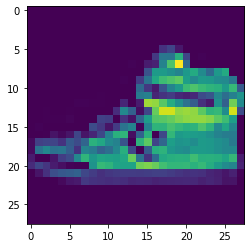

In [ ]:
plt.imshow(x_abnormal_train[80])

In [ ]:
x_test = x_test.reshape(x_test.shape[0], 28*28)
x_normal_train = x_normal_train.reshape(x_normal_train.shape[0], 28*28)

## ベースラインの評価

In [ ]:
from sklearn.svm import OneClassSVM

svm = OneClassSVM()
svm.fit(x_normal_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_score = svm.decision_function(x_test)
auc_baseline = roc_auc_score(y_test,y_score)
auc_baseline

0.509236

In [ ]:
def plot_roc(svm,x_test):
    y_score = svm.decision_function(x_test)
    auc = roc_auc_score(y_test,y_score)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label='baseline(AUC = %.2f)'%auc)
    plt.plot([0,1],[0,1],'k--')
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

In [ ]:
fpr_baseline, tpr_baseline, thresholds = roc_curve(y_test, y_score)

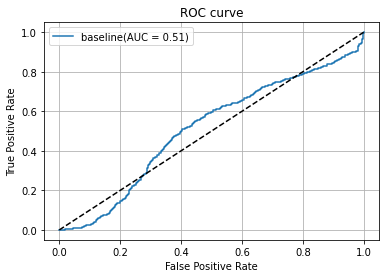

In [ ]:
plt.plot(fpr_baseline, tpr_baseline, label='baseline(AUC = %.2f)'%auc_baseline)
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

## オートエンコーダーを使って特徴量抽出した後にOne Class SVMによって異常検知

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

latent_dim = 2 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
    #   layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(32, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(784, activation='sigmoid'),
    #   layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(x_normal_train, x_normal_train,
                epochs=50,
                shuffle=True)

# decoded_imgs = autoencoder.decoder(features).numpy()

Epoch 1/50
188/188 [==============================] - 2s 5ms/step - loss: 0.0671
Epoch 2/50
188/188 [==============================] - 1s 4ms/step - loss: 0.0429
Epoch 3/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0364
Epoch 4/50
188/188 [==============================] - 1s 4ms/step - loss: 0.0329
Epoch 5/50
188/188 [==============================] - 1s 4ms/step - loss: 0.0318
Epoch 6/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0313
Epoch 7/50
188/188 [==============================] - 1s 4ms/step - loss: 0.0309
Epoch 8/50
188/188 [==============================] - 1s 4ms/step - loss: 0.0307
Epoch 9/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0305
Epoch 10/50
188/188 [==============================] - 1s 4ms/step - loss: 0.0304
Epoch 11/50
188/188 [==============================] - 1s 4ms/step - loss: 0.0303
Epoch 12/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0302
Epoch 13/50
188/188 [====

In [ ]:
svm = OneClassSVM()
x_normal_train = autoencoder.encoder(x_normal_train).numpy()
svm.fit(x_normal_train)

# x_test = autoencoder.encoder(x_test).numpy()
x_test = autoencoder.encoder(x_test).numpy()
# plot_roc(svm,x_test)

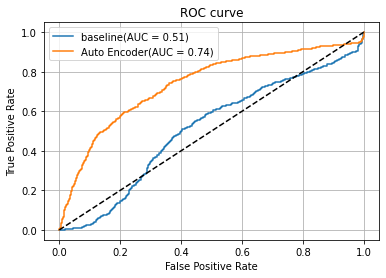

In [ ]:
y_score = svm.decision_function(x_test)
auc_ae = roc_auc_score(y_test,y_score)
fpr_ae, tpr_ae, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr_baseline, tpr_baseline, label='baseline(AUC = %.2f)'%auc_baseline)
plt.plot(fpr_ae, tpr_ae, label='Auto Encoder(AUC = %.2f)'%auc_ae)
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

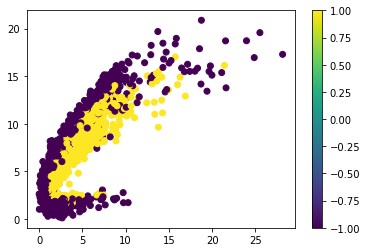

In [ ]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_pred)
plt.colorbar()


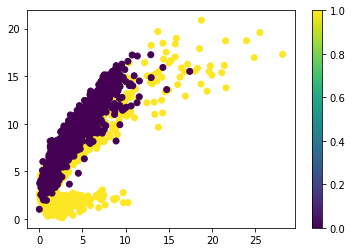

In [ ]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
plt.colorbar()

In [ ]:
y_pred = svm.predict(x_test)
y_pred = np.where(y_pred==-1,0,1)

def evaluate_detection(y_pred, y_test):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test,y_pred))
evaluate_detection(y_pred, y_test)

[[852 148]
 [495 505]]
              precision    recall  f1-score   support

         0.0       0.63      0.85      0.73      1000
         1.0       0.77      0.51      0.61      1000

    accuracy                           0.68      2000
   macro avg       0.70      0.68      0.67      2000
weighted avg       0.70      0.68      0.67      2000

